# Local Field Potental (LFP)

<div class="alert alert-block alert-info">


### ABOUT THIS LESSON 
---

Lesson time: 60 m   
Contributors: Davide Spalla


**In this lesson you will learn:**
- What the Local Field Potential is
- How to filter the LFP signals and compute its power spectrum
- How to identify prominent oscillations in the signal
- How to perform time-frequency analysis to compute how the power content of different frequencies varies over time
- How to detect oscillatory patterns using the instantaneous power trace



In [1]:
"""
DOCSTRING
"""

from pywt import scale2frequency
from pywt import cwt
from scipy.signal import butter
from scipy.signal import sosfilt
import numpy as np


def bandpass_filter(signal, low_f, high_f, sampling_rate=1.0, filter_order=5):
    '''
    Band pass filter based on the scipy implementation of butterwirth filtering.

    Returns the filtered signal in the specified frequency band.

    Parameters
    ----------
    signal : array-like
        the signal to filter

    low_f : float
        lower bound of the frequency band

    high_f : float
        higher bound of the frequency band

    sampling_rate : float
        sampling rate of the signal, defaults to 1 if not specified

    filter_order : int
        order of the butterwirth filter, defaults to 15 if not specified

    Returns
    -------
    filtered_signal : array-like
        filtered signal

    '''
    filter = butter(filter_order, [low_f, high_f],
                    btype='band', output='sos', fs=sampling_rate)
    filtered_signal = sosfilt(filter, signal)
    return filtered_signal


def morlet_transform(signal, low_f, high_f, n_freqs=20, sampling_rate=1.0):
    """
    Morlet transforms the signal in a given frequency band, with given frequency resolution

    Parameters
    ---------------------
    signal

    low_f

    high_f

    n_freqs

    sampling_rate

    Returns
    ---------------------
    C:
    freq:
    """
    frequencies = np.linspace(low_f, high_f, n_freqs)/sampling_rate
    scales = scale2frequency('cmor1-0.5', frequencies)
    C, freq = cwt(signal, wavelet='cmor1-0.5', scales=scales,
                  sampling_period=1.0/sampling_rate)
    return C, freq


def power(signal, low_f, high_f, sampling_rate=1.0, n_freqs=20):
    '''
    '''
    C, freq = morlet_transform(
        signal, low_f, high_f, sampling_rate=sampling_rate, n_freqs=n_freqs)
    power = np.mean(abs(C), axis=0)
    return power


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code/"))
import lfp_functions as lf

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})

In [16]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/7BosHgemAseANIc')

NameError: name 'download_data' is not defined

## Introduction
---
The Local [Field Potential (LFP)](http://www.scholarpedia.org/article/Local_field_potential#:~:text=The%20local%20field%20potential%20) is the name that neuroscientists use to refer to the extracellular electric potential, i.e. the potential in the space around neurons.   

The use of LFP signals to investigate neural activity is common in systems neuroscience, due to the relative ease of recording (a single electrode is sufficient to extract the signal) and the rich variety of oscillatory phenomena it allows to probe.

The LFP results from the activity of the local neural population (in contrast with electrocorticography and electroencefalography, whose signal is the result of the activity of large cortical areas), but it is not directly related to spiking activity: the main contribution to LFP comes from the postsynaptic membrane potentials.

In this lesson we will look at a series of preprocessing and analysis methods used in the analysis of LFP. They all rely on the fact that the LFP is a continuous signal (unlike spiking activity) usually sampled with very high time resolution (unlike calcium signals). This makes it tractable with a large family of signal processing tools.


 


## Fourier analysis and power spectrum
---
Continuous signals can often be decomposed as a superposition of elementary building blocks. For a signal that is sampled for a long time, a useful description is obtained by decomposing it as a sum of sine and cosine waves with different frequencies.
For a periodic signal of period $T$, this is called Fourier decomposition and is given by:

$$x(t)=\sum_{n=-\infty}^{+\infty} c_{n} e^{i\frac{2\pi}{T}nt}$$

The complex exponentials are oscillator with different frequencies, and the fourier coefficients $c_{n}$ represents the weight of each oscillator in the decomposition of the signal.
The weights $c_{n}$ are computed as 

$$c_{n}=\frac{1}{T}\int_{T}x(t)e^{i\frac{2\pi}{T}nt} dt$$

This formula can be roughly interpreted as the covariance of the signal $x(t)$ (when its average over $T$ is zero) with the oscillatory pattern $e^{i\frac{2\pi}{T}nt}$.

The fourier decomposition can be mathematically extended to non-periodic signals by sending the period $T$ to infinity. This is known as the Fourier transform.

By taking the square modulus of the coefficients $c_{n}$, we obtain the power spectrum of the signal, that we can use to gauge the contributions of different frequencies.

<div class="alert alert-block alert-info">

### Nyquist frequency

The sampling rate at which a signal is acquired sets a bound to the highest frequency that we can investigate with Fourier analysis. Intuitively, we do not have any information about variations in the signal that are *faster* than a sampling interval.

The maximum frequency that we can resolve is called [Nyquist_frequency](https://en.wikipedia.org/wiki/Nyquist_frequency), and it is half of the sampling rate

$$f_{max}=\frac{1}{2\Delta t}$$

Where $\Delta t$ is the time interval between samples.

<div class="alert alert-block alert-info">

### Detrending and de-averaging

Fourier analysis assumes a *stationary* signal, i.e. a signal whose property do not change over time. 
This is often not the case in data recorded from the brain: for example, the average of the signal can be different from the beginning of the recording to the end.

To avoid to pick up this difference as a low-frequency component, the signal is usually [detrended](): the variation of its mean from beginning to end is estimated (most commonly with a linear fit), and subtracted at each time from the original signal

$$\tilde{x}(t)= x(t)-(at+b)$$

Where $a$ and $b$ are estimated with a fitting procedure.

Also, usually the time average of the signal is subtracted to the signal itself: a non-zero average correspond to a big zero-frequency component, that can overshadow the rest of the power spectrum and is usually of no interest in the context of the frequency analysis.

$$\tilde{x}(t)=x(t)-<x(t)>_{T}$$


### Example: theta rythm in moving rodents
---
The [theta rythm](https://en.wikipedia.org/wiki/Theta_wave) is a well known oscillatory pattern with a frequency of around 8 Hz that can be seen in the hippocampus of rodents during wake activity, and is particularly prominent [during locomotion](https://www.sciencedirect.com/science/article/abs/pii/S0006899398003904?via%3Dihub).  

There are many hypothesis on the potential role of the theta oscillation, see [this review](https://www.annualreviews.org/doi/abs/10.1146/annurev-neuro-062012-170330) for an overview.

We will use fourier analysis, and in particular the [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform) algorithm to look at how the theta rythm shows in data recoded from a mouse moving around in an arena.  


First, let's import the data: around ten minutes of LFP signal, recorded at a rate of 1000 Hz.

In [3]:
with open('moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


Text(0, 0.5, 'voltage (mV)')

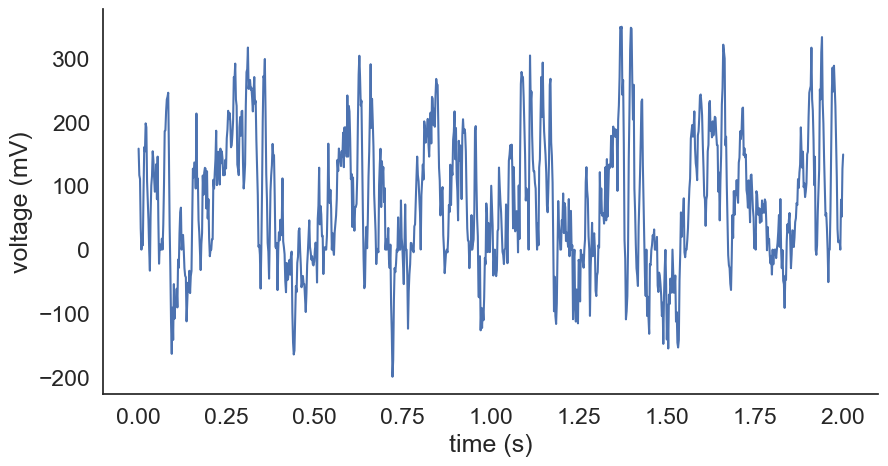

In [4]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,2,1000),lfp[1000:2000])
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')

There is a lot going on here, but a first thing that meets the eye is a rather prominent oscilaltion at around 8 Hz (8 times per second). Can we see it in the power spectrum? Let's look!

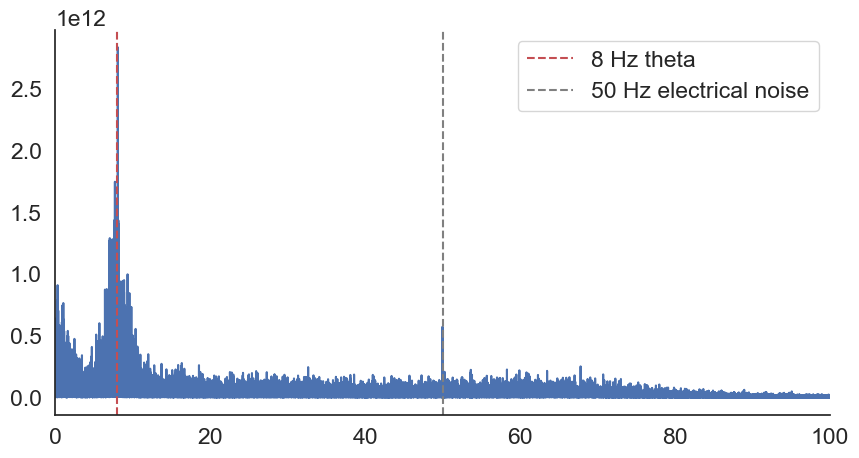

In [5]:
from scipy.fft import fft, fftfreq

n_samples = len(lfp)
sample_dt = 1. / sampling_rate

# we subtract the mean to get rid of the 0 frequency component in the spectrum
centered_lfp = lfp - np.mean(lfp)

transformed_signal = fft(centered_lfp) 

frequencies = fftfreq(n_samples,sample_dt) 

transformed_signal = transformed_signal[:n_samples//2]
frequencies = frequencies[:n_samples//2]

power = abs(transformed_signal)**2

plt.figure(figsize = (10,5))
plt.plot(frequencies,power)
plt.xlim([0,100]) # restrict to 
plt.axvline(x=8 ,c='r',linestyle='--',label='8 Hz theta')
plt.axvline(x=50 ,c='grey',linestyle='--',label='50 Hz electrical noise')

plt.legend()

We can see a clear peak around 8Hz. This is the well studied [theta frequency] band. In rodents, large activity in the theta band is known to be related to active behaviour and locomotion in particular. This makes sense with our data, that where collected from a mouse moving around in an arena.

Computing the frequency power spectrum over the whole session yields information about the frequency content of the overall signal, but erases all temporal features. To see more in detail what is happening at any given time, we have to move to [time-frequency analysis](https://en.wikipedia.org/wiki/Time%E2%80%93frequency_analysis) methods. Before doing that, let's look at a few useful concepts and techniques in signal porcessing.

## Filtering
---
 A filter is a device that removes unwanted component of a signal. We will look at frequency filters, that get rid of some of the frequencies in the LFP time series.
In the jargon, a *low-pass* filter is a filter getting rid of all the frequencies above a certain threshold frequency, a *high pass* filter eliminates all frequencies below a threshold, and a *band pass* filter, combining the two, will filter the signal in a given frequency band.

In particular, we want to fitler out very low frequency components (as we did when we sbtracted the signal average, which can be interpreted as filtering away the 0 frequency component), and very high frequency, that act as noise for the scale we are interested to investigate.


We won't go into the details of the mathematics of filters here. We will use the scipy implementation of a [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter), a filter that can be expressed as a complex polynomial of a chosen oder, and designed to have a response that is as flat as possible in the pass band, to avoid distorsion of the filtered signal.

<figure> 
<img src="imgs/butterworth_transfer.png" alt="tranfer" width="600" height=400>
<figcaption>
Frequency transfer function of a low-pass butterworth filter with cutoff frequency = 1. Note the log scale on the x axis.
</figcaption>
 </figure>


We will with the `scipy.signal.sosfilt` function, that applies the 'cascaded second order section method', a numerically stable implementation of the standard convolution procedure, that breaks a polynomial filter of high order in sequential application of second order filters.

Text(0, 0.5, 'voltage (mV)')

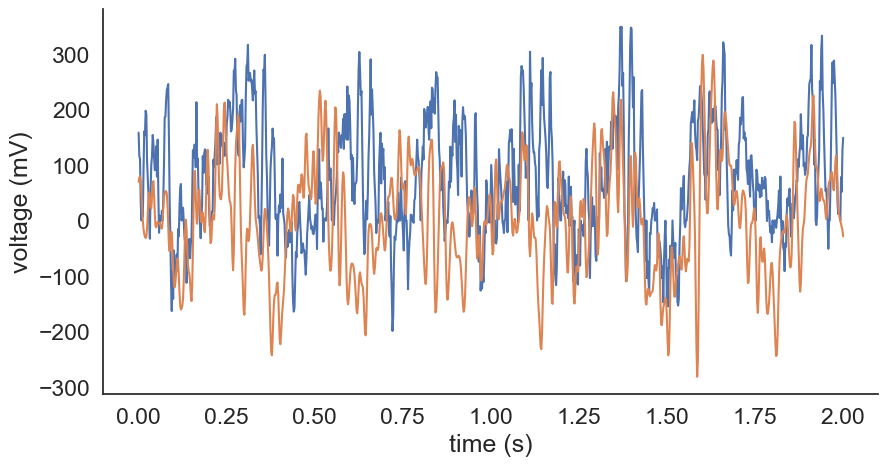

In [6]:
from scipy.signal import butter
from scipy.signal import sosfilt

filter_order = 200 #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability
low_f = 1
high_f = 200

#define filter object
filter = butter(filter_order,[low_f,high_f],
                btype='band', 
                output='sos', 
                fs=sampling_rate)
                
#apply filter to lfp       
wideband_lfp = sosfilt(filter, lfp)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,2,1000),lfp[1000:2000],label='raw signal')
plt.plot(np.linspace(0,2,1000),wideband_lfp[1000:2000],label = 'wideband filtered')
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')

Wideband filtering is commonly used to get rid of very low frequency information (such as the average value of the signal, as we did before by centering), and very high components. This allows us to concetrate on the part of the signal that we are interested in (the 1-200 Hz range is a typical one for hippocampal LFP, but this can change for different signals).

We can use filters also to isolate a the particular frequency bands that we are interested in. Below, for example, we can isolate the theta band (8-12 Hz) the slow gamma gamma (20-45 Hz) and the fast gamma (100-140 Hz) components.
We'll use a version of the code above that we wrapped in a `bandpass_filter` function.

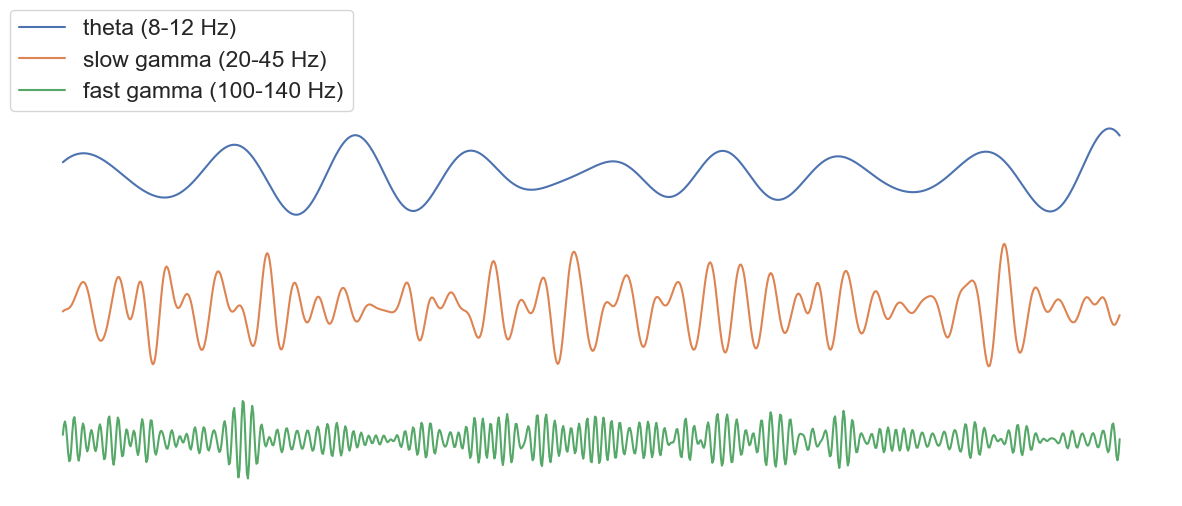

In [7]:
theta_lfp = lf.bandpass_filter(lfp,low_f=8,high_f=12, sampling_rate=sampling_rate)
slow_gamma_lfp = lf.bandpass_filter(lfp,low_f=20,high_f=45, sampling_rate=sampling_rate)
fast_gamma_lfp = lf.bandpass_filter(lfp,low_f=100,high_f=140, sampling_rate=sampling_rate)
plot_offset = 200 #to plot the signal on different lines

plt.figure(figsize=(15,5))
plt.plot(theta_lfp[1000:2000]+2*plot_offset,label='theta (8-12 Hz)')
plt.plot(slow_gamma_lfp[1000:2000]+plot_offset,label = 'slow gamma (20-45 Hz)')
plt.plot(fast_gamma_lfp[1000:2000],label = 'fast gamma (100-140 Hz)')

plt.axis('off')
plt.legend(loc=(0,1))


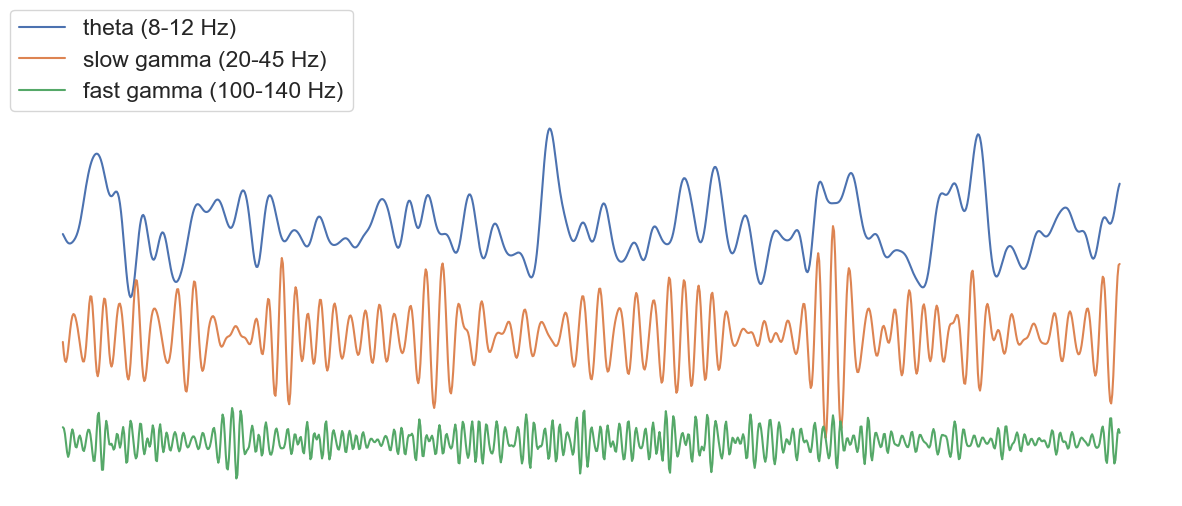

In [8]:
theta_lfp = lf.bandpass_filter(lfp,low_f=8,high_f=45, sampling_rate=sampling_rate)
slow_gamma_lfp = lf.bandpass_filter(lfp,low_f=50,high_f=90, sampling_rate=sampling_rate)
fast_gamma_lfp = lf.bandpass_filter(lfp,low_f=100,high_f=180, sampling_rate=sampling_rate)
plot_offset = 200 #to plot the signal on different lines

plt.figure(figsize=(15,5))
plt.plot(theta_lfp[1000:2000]+2*plot_offset,label='theta (8-12 Hz)')
plt.plot(slow_gamma_lfp[1000:2000]+plot_offset,label = 'slow gamma (20-45 Hz)')
plt.plot(fast_gamma_lfp[1000:2000],label = 'fast gamma (100-140 Hz)')

plt.axis('off')
plt.legend(loc=(0,1))
%timeit

### Excercise 1
When I changed the frequency order to 300 the computing time was a bit slower, about 1 sec.
The filter gets more selective and only permits a smaller range of frequencies to pass through when the bandwidth of the frequency band is reduced.
The filtered signal will be more centered around its central frequency and exhibit increased attenuation of frequencies outside the smaller band.
Expanding the frequency band's bandwidth permits a wider variety of frequencies to go through the filter.
More of the original information will be retained in the filtered signal since it will show less attenuation of frequencies outside the larger band.
The range of frequencies that pass through the filter will change if the band's center frequency is changed.
The passband will move towards higher frequencies when the central frequency is increased, and towards lower frequencies when it is decreased.
The computation time was somewhat longer, roughly one second when I adjusted the frequency order to 300.

## Time-frequency analysis
---

In [9]:
from scipy import signal
from pywt import scale2frequency
from pywt import cwt

### Wavelets
A wavelet is a **localized** oscillatory pattern. This means that, unlike the sine or cosine waves that extend indefinitely, the wavelet function $\Psi$ has finite energy:
$$\int_{- \infty}^{+\infty} |\Psi(x)|^{2} dx = E < \infty$$

This is usually achieved by constructing the wavelet function as an oscillatory function multiplied by a (typically exponential) decaying function.  

A popular example is the morlet wavelet, with a cosine wave multiplied by a gaussian window (this is the real morlet wavelet, we will get to know its complex sibling soon).

$$\Psi(x,\omega) = K \cos(\omega x)e^{-x^{2}} $$

The parameter $\omega$ determines the carrier frequencies, i.e. how many oscillations the wavelet is able to make before total dampening.

Once we have our base wavelet, we can construct a whole family of them, by *translating* and *scaling* the bas function:
$$\Psi_{a,b}= K_{a} \Psi(\frac{x-b}{a})$$

This functions will substitute the sines and cosines, and be the basis of the morlet transform.

But first, let's look at the morlet wavelet: in the plot below, we can change the carrier frequency $\omega$ and the scale $a$, to see what effect they have on the function.

In [10]:
from ipywidgets import interact
import ipywidgets as widgets


def plot_wavelet(scale,freq):
    plt.figure(figsize=(10,5))
    wavelet = signal.morlet(1000,s=scale,w=freq)
    envelope = abs(wavelet)
    plt.plot(wavelet.real,label='wavelet (real part)')
    plt.plot(envelope, label = 'envelope')
    plt.legend(loc=[1,1])
    plt.axis('off')

interact(plot_wavelet, scale = widgets.FloatSlider(min=.05, max=2, value=.5),
                       freq = widgets.FloatSlider(min=1, max=20, value=5))

interactive(children=(FloatSlider(value=0.5, description='scale', max=2.0, min=0.05), FloatSlider(value=5.0, d…

<function __main__.plot_wavelet(scale, freq)>

### Continuous wavelet transform
The [continuous wavelet transform](https://en.wikipedia.org/wiki/Continuous_wavelet_transform) works in a conceptually similar way to the Fourier transform, but with a different set of basis functions made by the chosen wavelet shape with different scales and locations.  
The contribution of each wavelet is computed with a convolution with the signal.  
Since the wavelet is a *localized* pattern, it's convolution with the signal gives information about a given frequency at a given time.  
As for the fourier transform, we can use a complex wavelet to take into account the phase of the signal.

In [11]:
from pywt import wavelist

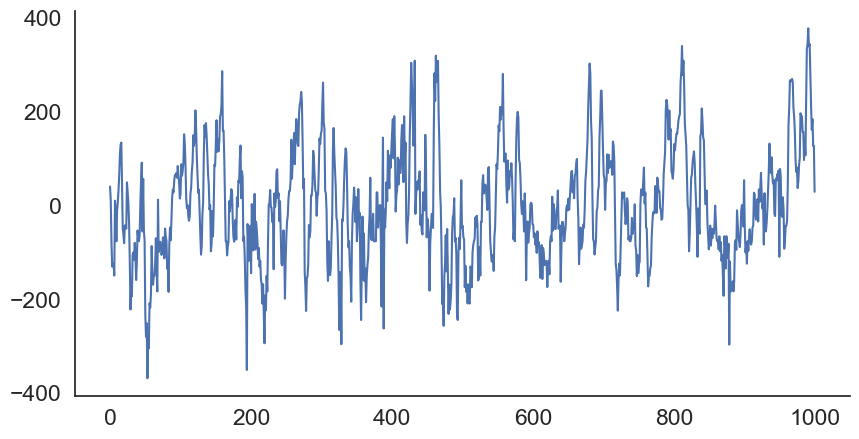

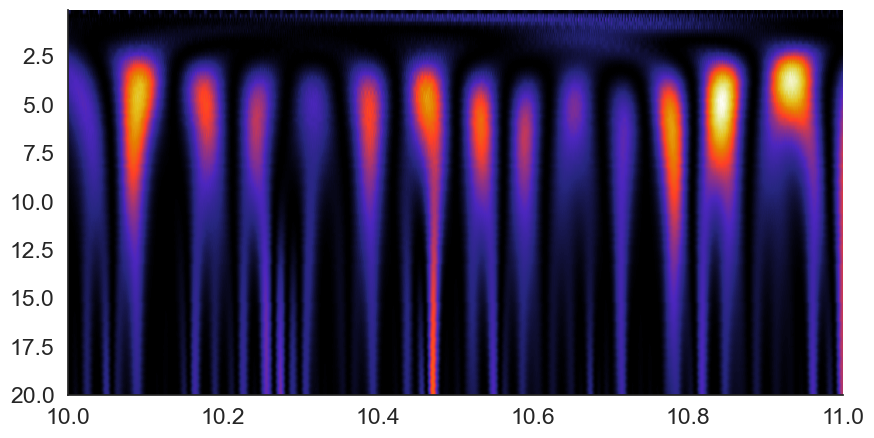

In [12]:
# GAUS
from pywt import scale2frequency
from pywt import cwt

start = 10 #in seconds
end = 11 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

plt.figure(figsize=(10,5))
plt.plot(sig)

#spectrogram with morlet transform

frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet = 'gaus1'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')


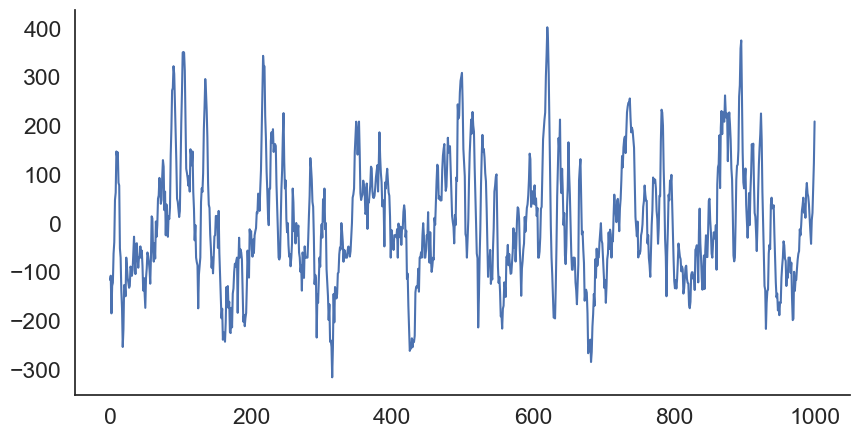

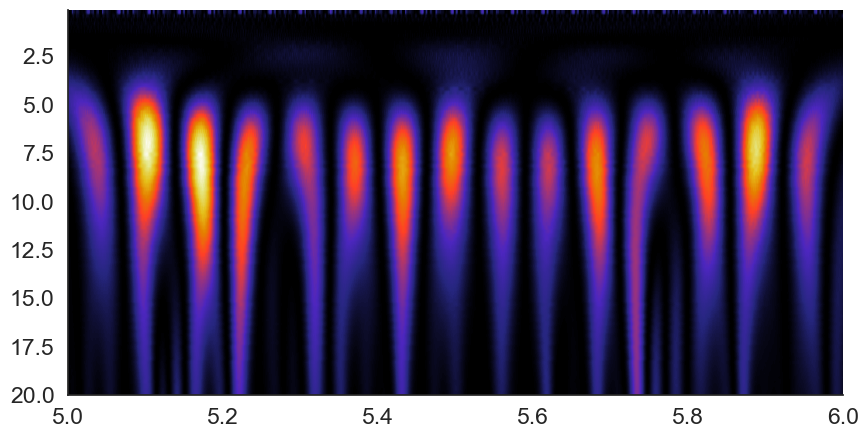

In [13]:
# MEXH
from pywt import scale2frequency
from pywt import cwt

start = 5 #in seconds
end = 6 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

plt.figure(figsize=(10,5))
plt.plot(sig)

#spectrogram with morlet transform

frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet = 'mexh'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')


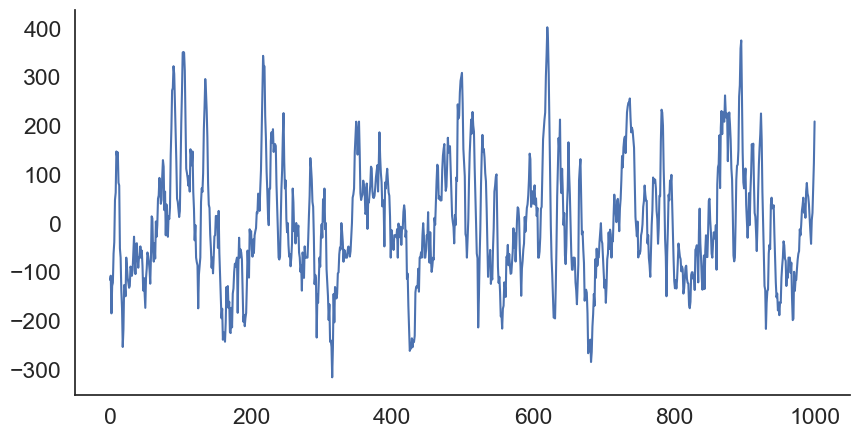

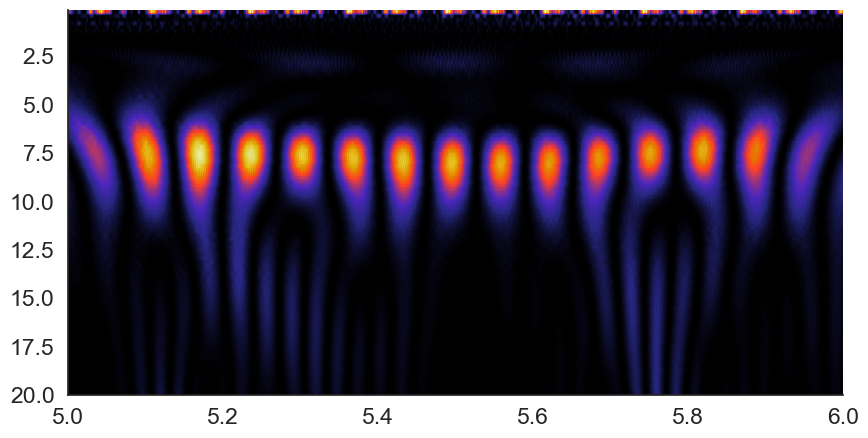

In [14]:
# MORL
from pywt import scale2frequency
from pywt import cwt

start = 5 #in seconds
end = 6 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

plt.figure(figsize=(10,5))
plt.plot(sig)

#spectrogram with morlet transform

frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet = 'morl'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')


We can use the wavelet transform to compute the instantaneous power in a given frequency band: we take the spectrogram above, restrict it to the frequency band of interest and average it over frequencies (along the vertical axis). This gives us the average oscillatory power in the selected frequency band at each moment in time.

Text(0, 0.5, 'power (a.u.)')

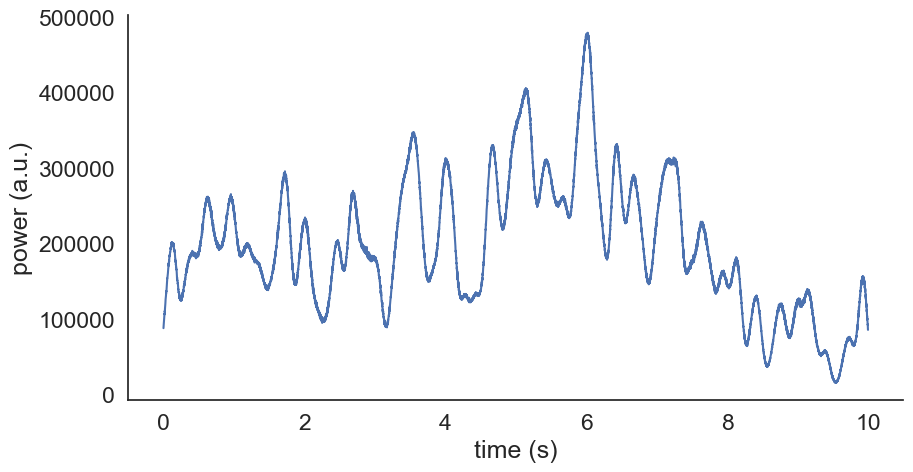

In [15]:
start = 0 #in seconds
end = 10 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

frequencies =  np.linspace(6,10,50)/sampling_rate
wavelet = 'cmor1.0-1.0'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)

power = np.mean(abs(cwtmatr)**2,axis=0)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(power)),power)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')

### Excercise 2
With a few minor variations, the Mexican hat and Gaussian wavelets appear to be rather similar. The Morlet wavelet, however, has an entirely different appearance. This may be explained by the fact that the Gaussian wavelet, which offers consistent frequency resolution across various scales, is frequently employed for short-time Fourier transform (STFT) research due to its symmetric structure and constant frequency content. Nevertheless, the Gaussian wavelet is less effective at assessing signals with abrupt changes or sharp features since it cannot simultaneously give adequate localization in both time and frequency.
In contrast, a complex sinusoid modulated by a Gaussian envelope in the time domain is known as a morlet wavelet.
When compared to a Gaussian wavelet, this modulation via a Gaussian envelope offers superior localization in terms of both time and frequency.
But as frequency increases, the Morlet wavelet's frequency resolution reduces, making it less suitable for evaluating signals with highly variable frequency components.

### Example: ripple detection
---
[Sharp Wave Ripples (SWRs)](https://www.nature.com/articles/s41583-018-0077-1) are a prominent oscillation pattern found in the CA1 region of the hippocampus, during sleep or awake rests. They have been hypothesized to play an important role in the cortical consolidation of memories formed into the hippocampus (see this paper for a review: https://www.nature.com/articles/s41583-018-0077-1).

We will use the wavelet transform to detect ripples from an LFP trace recorded in the hippocampus of a sleeping mouse. 

In [16]:
with open('sleep_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

sleep_lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


In [17]:
def compute_ripple_power(signal,sampling_rate,low_f=100,high_f=250):
    '''Takes lfp signal and sampling rate, returns instantaneous power in the specified band 
    (default is ripple band 100-250 Hz)'''
    signal = signal - np.mean(signal) # get rid of 0 frequency component


    frequencies =  np.linspace(low_f,high_f,50)/sampling_rate
    wavelet = 'cmor1.0-1.0'
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(signal, wavelet=wavelet, scales=scales,
                    sampling_period=1.0/sampling_rate)


    power = np.mean(abs(cwtmatr)**2,axis=0)

    return power

def ripple_idxs(ripple_mask):
    '''
    Takes logical ripple mask and returns a list of arrays. Each array correspond to a ripple
    and contains its time idxs (relative to the provided ripple mask)
    '''
    ripple_starts = []
    ripple_ends = []
    for i in range(1, len(ripple_mask)):
        if ripple_mask[i-1] == 0 and ripple_mask[i] == 1:
            ripple_starts.append(i)
        if ripple_mask[i-1] == 1 and ripple_mask[i] == 0:
            ripple_ends.append(i)

    # handle edge cases
    if len(ripple_ends) > len(ripple_starts):
        ripple_starts = [0]+ripple_starts  # if session starts with a ripple

    if len(ripple_ends) < len(ripple_starts):
        ripple_ends.append(len(ripple_mask))  # if session ends with a ripple

    ripples = [np.arange(ripple_starts[i], ripple_ends[i])
               for i in range(len(ripple_starts))]

    return ripples

def clean_ripples(ripples,lfp,ripple_len_th=None,amplitude_th=None):
    '''takes list of ripples and corresponding signal, returns list of ripples cleaned of ripple that are shorter than specified 
    duration threshold or with amplitude larger than specified amplitude threshold (usually artifacts)'''
    clean_ripples = [r for r in ripples if (len(r)>ripple_len_th and \
                    max(lfp[r])< amplitude_th and min(lfp[r])>-amplitude_th)] 
    return clean_ripples

In [18]:
from scipy.stats import zscore

ripple_th = 2

ripple_power = compute_ripple_power(sleep_lfp,sampling_rate)
zscored_power = zscore(ripple_power)

ripple_mask = np.asarray([True if x>ripple_th else 0 for x in zscored_power])

ripples = ripple_idxs(ripple_mask)

ripples = clean_ripples(ripples,sleep_lfp,ripple_len_th=30, amplitude_th=1000)

print(f'detected {len(ripples)} ripples')

detected 23 ripples


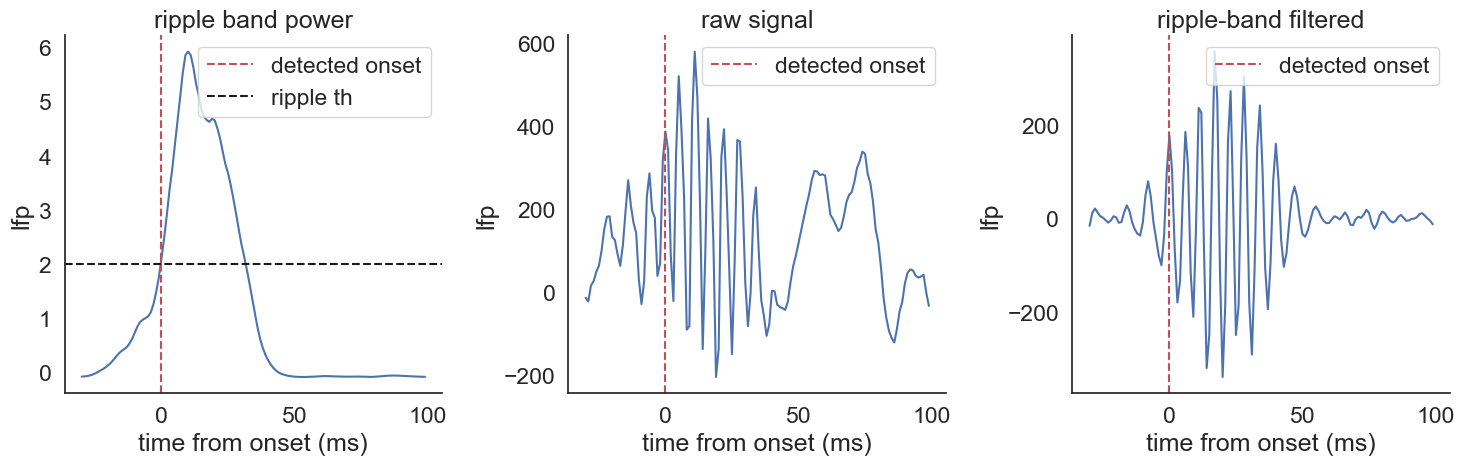

In [19]:
ripple_n = 1

ripple_lfp = lf.bandpass_filter(sleep_lfp,low_f=100,high_f=250, sampling_rate=sampling_rate)


plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = zscored_power[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.axhline(y=2,linestyle='--',c='k',label='ripple th')

plt.title('ripple band power')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()

plt.subplot(1,3,2)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = sleep_lfp[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.title('raw signal')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()

plt.subplot(1,3,3)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = ripple_lfp[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.title('ripple-band filtered')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()
plt.tight_layout()


detected 50 ripples


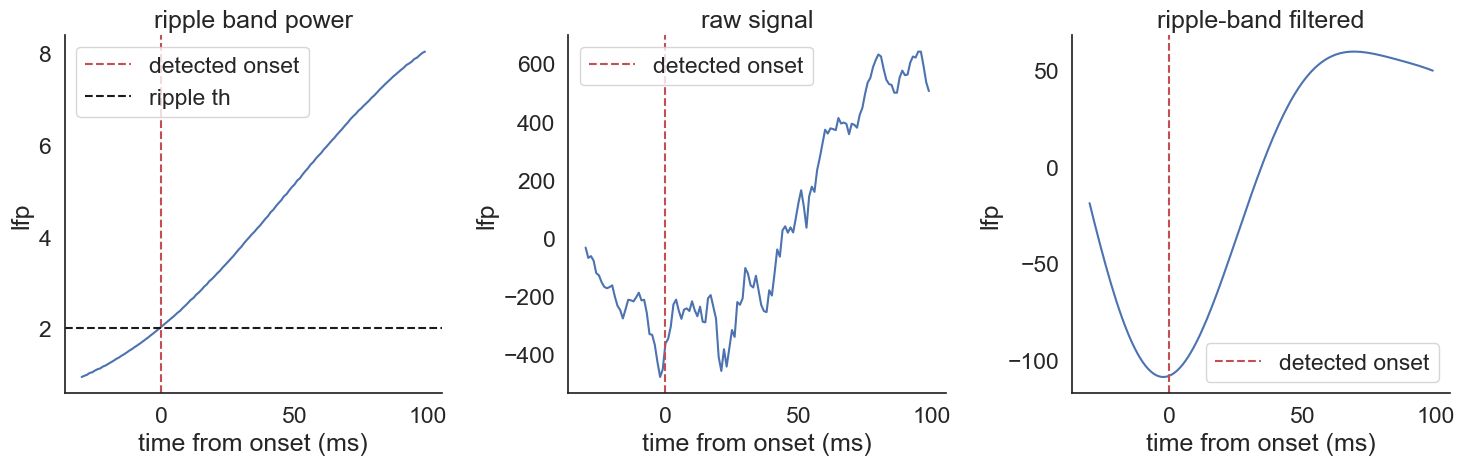

In [21]:
###### Theta Ripples
def compute_ripple_power(signal,sampling_rate,low_f=6,high_f=10):
    signal = signal - np.mean(signal) # get rid of 0 frequency component


    frequencies =  np.linspace(low_f,high_f,200)/sampling_rate
    wavelet = 'cmor1.0-1.0'
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(signal, wavelet=wavelet, scales=scales,
                    sampling_period=1.0/sampling_rate)


    power = np.mean(abs(cwtmatr)**2,axis=0)

    return power

def ripple_idxs(ripple_mask):
    '''
    Takes logical ripple mask and returns a list of arrays. Each array correspond to a ripple
    and contains its time idxs (relative to the provided ripple mask)
    '''
    ripple_starts = []
    ripple_ends = []
    for i in range(1, len(ripple_mask)):
        if ripple_mask[i-1] == 0 and ripple_mask[i] == 1:
            ripple_starts.append(i)
        if ripple_mask[i-1] == 1 and ripple_mask[i] == 0:
            ripple_ends.append(i)

    # handle edge cases
    if len(ripple_ends) > len(ripple_starts):
        ripple_starts = [0]+ripple_starts  # if session starts with a ripple

    if len(ripple_ends) < len(ripple_starts):
        ripple_ends.append(len(ripple_mask))  # if session ends with a ripple

    ripples = [np.arange(ripple_starts[i], ripple_ends[i])
               for i in range(len(ripple_starts))]

    return ripples

def clean_ripples(ripples,lfp,ripple_len_th=None,amplitude_th=None):
    '''takes list of ripples and corresponding signal, returns list of ripples cleaned of ripple that are shorter than specified 
    duration threshold or with amplitude larger than specified amplitude threshold (usually artifacts)'''
    clean_ripples = [r for r in ripples if (len(r)>ripple_len_th and \
                    max(lfp[r])< amplitude_th and min(lfp[r])>-amplitude_th)] 
    return clean_ripples

from scipy.stats import zscore

ripple_th = 2

ripple_power = compute_ripple_power(sleep_lfp,sampling_rate)
zscored_power = zscore(ripple_power)

ripple_mask = np.asarray([True if x>ripple_th else 0 for x in zscored_power])

ripples = ripple_idxs(ripple_mask)

ripples = clean_ripples(ripples,sleep_lfp,ripple_len_th=30, amplitude_th=1000)

print(f'detected {len(ripples)} ripples')

### Theta ripple
ripple_n = 1

ripple_lfp = lf.bandpass_filter(sleep_lfp,low_f=6,high_f=10, sampling_rate=sampling_rate)


plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = zscored_power[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.axhline(y=2,linestyle='--',c='k',label='ripple th')

plt.title('ripple band power')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()

plt.subplot(1,3,2)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = sleep_lfp[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.title('raw signal')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()

plt.subplot(1,3,3)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = ripple_lfp[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.title('ripple-band filtered')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()
plt.tight_layout()


detected 5 ripples


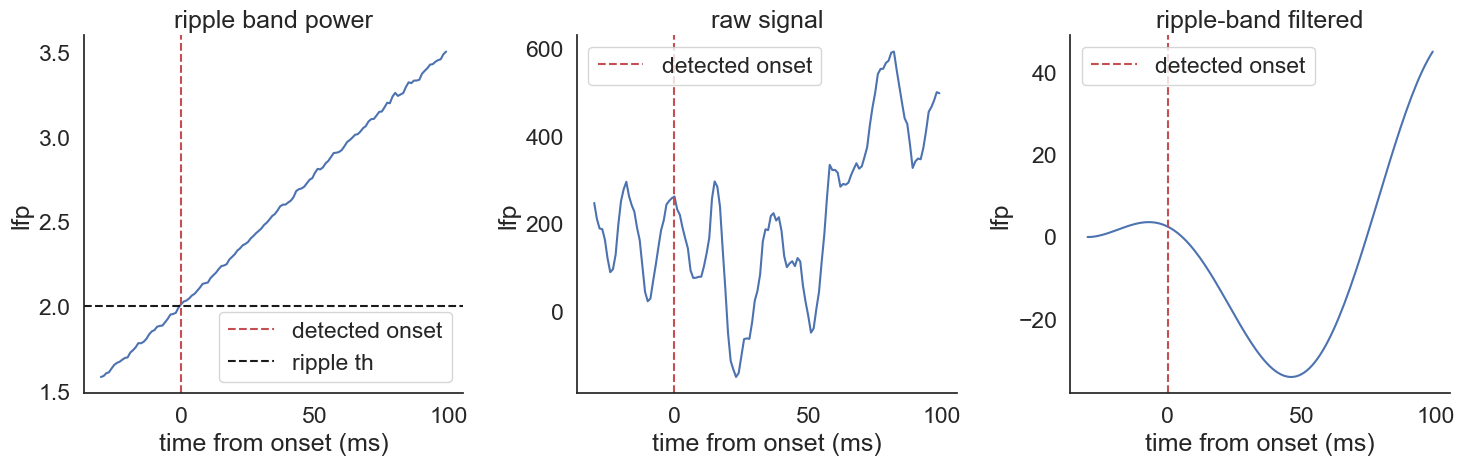

In [22]:
###### Delta Ripples
def compute_ripple_power(signal,sampling_rate,low_f=2,high_f=4):
    signal = signal - np.mean(signal) # get rid of 0 frequency component


    frequencies =  np.linspace(low_f,high_f,50)/sampling_rate
    wavelet = 'cmor1.0-1.0'
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(signal, wavelet=wavelet, scales=scales,
                    sampling_period=1.0/sampling_rate)


    power = np.mean(abs(cwtmatr)**2,axis=0)

    return power

def ripple_idxs(ripple_mask):
    '''
    Takes logical ripple mask and returns a list of arrays. Each array correspond to a ripple
    and contains its time idxs (relative to the provided ripple mask)
    '''
    ripple_starts = []
    ripple_ends = []
    for i in range(1, len(ripple_mask)):
        if ripple_mask[i-1] == 0 and ripple_mask[i] == 1:
            ripple_starts.append(i)
        if ripple_mask[i-1] == 1 and ripple_mask[i] == 0:
            ripple_ends.append(i)

    # handle edge cases
    if len(ripple_ends) > len(ripple_starts):
        ripple_starts = [0]+ripple_starts  # if session starts with a ripple

    if len(ripple_ends) < len(ripple_starts):
        ripple_ends.append(len(ripple_mask))  # if session ends with a ripple

    ripples = [np.arange(ripple_starts[i], ripple_ends[i])
               for i in range(len(ripple_starts))]

    return ripples

def clean_ripples(ripples,lfp,ripple_len_th=None,amplitude_th=None):
    '''takes list of ripples and corresponding signal, returns list of ripples cleaned of ripple that are shorter than specified 
    duration threshold or with amplitude larger than specified amplitude threshold (usually artifacts)'''
    clean_ripples = [r for r in ripples if (len(r)>ripple_len_th and \
                    max(lfp[r])< amplitude_th and min(lfp[r])>-amplitude_th)] 
    return clean_ripples

from scipy.stats import zscore

ripple_th = 2

delta_ripple_power = compute_ripple_power(sleep_lfp,sampling_rate)
delta_zscored_power = zscore(delta_ripple_power)

ripple_mask = np.asarray([True if x>ripple_th else 0 for x in delta_zscored_power])

delta_ripples = ripple_idxs(ripple_mask)

delta_ripples = clean_ripples(delta_ripples,sleep_lfp,ripple_len_th=30, amplitude_th=1000)

print(f'detected {len(delta_ripples)} ripples')


### Delta ripple
ripple_n = 1

delta_ripple_lfp = lf.bandpass_filter(sleep_lfp,low_f=2,high_f=4, sampling_rate=sampling_rate)


plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
onset = delta_ripples[ripple_n][0]
x = np.arange(-30,100)
y = delta_zscored_power[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.axhline(y=2,linestyle='--',c='k',label='ripple th')

plt.title('ripple band power')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()

plt.subplot(1,3,2)
onset = delta_ripples[ripple_n][0]
x = np.arange(-30,100)
y = sleep_lfp[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.title('raw signal')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()

plt.subplot(1,3,3)
onset = delta_ripples[ripple_n][0]
x = np.arange(-30,100)
y = ripple_lfp[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.title('ripple-band filtered')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()
plt.tight_layout()

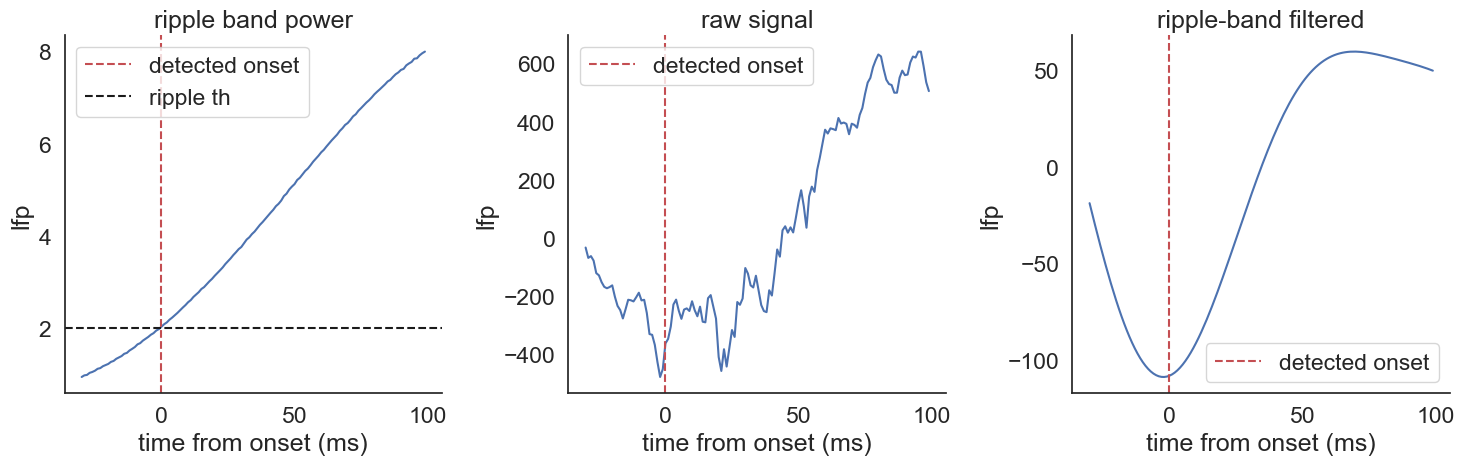

In [19]:
### Theta ripple
ripple_n = 1

ripple_lfp = lf.bandpass_filter(sleep_lfp,low_f=6,high_f=10, sampling_rate=sampling_rate)


plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = zscored_power[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.axhline(y=2,linestyle='--',c='k',label='ripple th')

plt.title('ripple band power')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()

plt.subplot(1,3,2)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = sleep_lfp[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.title('raw signal')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()

plt.subplot(1,3,3)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = ripple_lfp[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.title('ripple-band filtered')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()
plt.tight_layout()


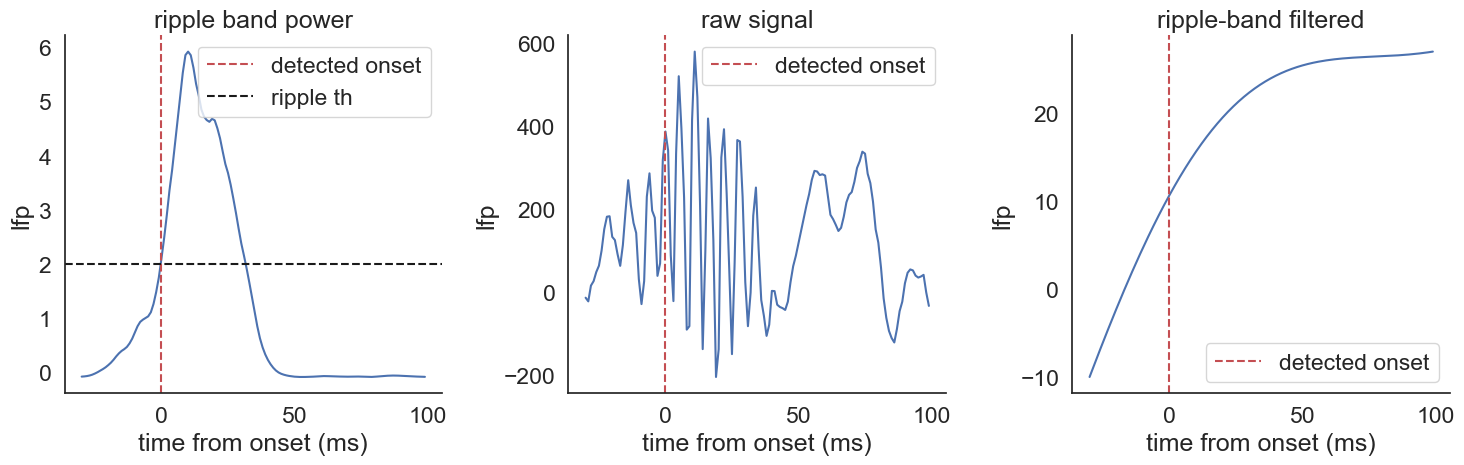

In [23]:
### Delta ripple
ripple_n = 1

ripple_lfp = lf.bandpass_filter(sleep_lfp,low_f=2,high_f=4, sampling_rate=sampling_rate)


plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = zscored_power[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.axhline(y=2,linestyle='--',c='k',label='ripple th')

plt.title('ripple band power')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()

plt.subplot(1,3,2)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = sleep_lfp[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.title('raw signal')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()

plt.subplot(1,3,3)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = ripple_lfp[onset-30:onset+100]
plt.plot(x,y)
plt.axvline(x=0,linestyle='--',c='r',label='detected onset')
plt.title('ripple-band filtered')
plt.xlabel('time from onset (ms)')
plt.ylabel('lfp')
plt.legend()
plt.tight_layout()


<div class="alert alert-block alert-info">


### Key points 

- The fourier transform of the LFP signal gives information about its frequency content (i.e. which frequencies are have more weights) on average in the given observation window.
- Filtering can be used to isolate and inspect the signal in certain frequency bands, as well as eliminating the high or low frequency component when they get in our way.
- Time-Frequency analysis, with wavelet transforms, can give insights about the local, time-by-time frequency content
- There is a foundamental tradeoff between the time and frequency resolution, due to the uncertainty principle

<div class="alert alert-block alert-info">


### References and resources

**Books & papers**
*  a Scholarpedia aricle of LFP and its interpretation http://www.scholarpedia.org/article/Local_field_potential#:~:text=The%20local%20field%20potential%20



## Exercises
You can find the exercises for this lessons in [exercises.ipynp](exercises.ipynb)